## Deploy Llava 1.6 with Mistral 7B Endpoint on SageMaker


#### LMI is shipping vLLM 0.4.2 with 0.28.0 containers, so technically we support all LLM that vLLM 0.4.2 support.

https://docs.djl.ai/master/docs/serving/serving/docs/lmi/user_guides/vllm_user_guide.html

Multi Modal Models support with 0.28.0 containers 

- LlaVA-NeXT (llava-hf/llava-v1.6-mistral-7b-hf, llava-hf/llava-v1.6-vicuna-7b-hf, etc.)
- Phi-3-Vision (microsoft/Phi-3-vision-128k-instruct, etc.)

### Setup

In this notebook, we will deploy a Llava 1.6 endpoint with DJLServing container image.

This notebook has been tested within SageMaker Studio Notebook Instance with pytorch environment. 

This notebook has been tested on Amazon SageMaker Notebook Instances with single GPU on ml.g5.2xlarge

In [112]:
!pip install huggingface_hub transformers==4.41.0 --upgrade --quiet

In [ ]:
!pip install sagemaker boto3 --upgrade

In [114]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import os
import time
import json
from pathlib import Path
import json
import base64

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


In [115]:
role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

In [116]:
model_bucket = sess.default_bucket()  # bucket to house artifacts
s3_code_prefix = "llava16-code"  # folder within bucket where code artifact will go
s3_model_prefix = "model-llava16"  # folder within bucket where code artifact will go
region = sess._region_name
account_id = sess.account_id()

s3_client = boto3.client("s3")
sm_client = boto3.client("sagemaker")
smr_client = boto3.client("sagemaker-runtime")

jinja_env = jinja2.Environment()

# define a variable to contain the s3url of the location that has the model
pretrained_model_location = f"s3://{model_bucket}/{s3_model_prefix}/"
print(f"Pretrained model will be uploaded to ---- > {pretrained_model_location}")

Pretrained model will be uploaded to ---- > s3://sagemaker-us-east-1-707684******/model-llava16/


## Prepare inference script and container image

Starting LMI V10 (0.28.0), we are changing the name from LMI DeepSpeed DLC to LMI (LargeModelInference). 

https://github.com/aws/deep-learning-containers/blob/master/available_images.md

In [117]:
# get the lmi image uri
# available frameworks: "djl-lmi" (for vllm, lmi-dist), "djl-tensorrtllm" (for tensorrt-llm), "djl-neuronx" (for transformers neuronx)

inference_image_uri = image_uris.retrieve(
    framework="djl-lmi", region=sess.boto_session.region_name, version="0.29.0"
)
inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.29.0-lmi11.0.0-cu124'

In this notebook, we will provide two ways to load the model when deploying to an endpoint.
- Directly load from Hugging Face 
- Store the model artifacts on S3 and load the model directly from S3

The [Large Model Inference (LMI)](https://docs.aws.amazon.com/sagemaker/latest/dg/large-model-inference-dlc.html) container uses [s5cmd](https://github.com/peak/s5cmd) to download data from S3 which significantly reduces the speed when loading model during deployment. Therefore, we recommend to load the model from S3 by following the below section to download the model from Hugging Face and upload the model on S3. 

If you choose to load the model directly from Hugging Face during model deployment, you can skip the below section and jump to the section to **prepare the model tarbal file and upload to S3**.

### [OPTIONAL] Download the model from Hugging Face and upload the model artifacts on Amazon S3
If you intend to download your copy of the model and upload it to a s3 location in your AWS account, please follow the below steps, else you can skip to the next step.

In [118]:
from huggingface_hub import snapshot_download
from pathlib import Path

model_name = "llava-hf/llava-v1.6-mistral-7b-hf"

# - This will download the model into the current directory where ever the jupyter notebook is running
local_model_path = Path("./llava-model")
local_model_path.mkdir(exist_ok=True)
# Only download pytorch checkpoint files
allow_patterns = ["*.json", "*.pt", "*.bin", "*.txt", "*.model", "*.safetensors"]

# - Leverage the snapshot library to donload the model since the model is stored in repository using LFS
model_download_path = snapshot_download(
    repo_id=model_name,
    cache_dir=local_model_path,
    allow_patterns=allow_patterns,
)

Fetching 14 files:   0%|          | 0/14 [00:00<?, ?it/s]

In [119]:
model_download_path

'llava-model/models--llava-hf--llava-v1.6-mistral-7b-hf/snapshots/216670a16460adb7c41ce3e123ceb3859f73ab12'

Please make sure the file is downloaded correctly by checking the files exist in the newly created folder `llava-model/models--llava-hf--llava-v1.6-mistral-7b-hf` before running the below cell.

In [120]:
# upload the model artifacts to s3
model_artifact = sess.upload_data(path=model_download_path, key_prefix=s3_model_prefix)
print(f"Model uploaded to --- > {model_artifact}")
print(f"We will set option.s3url={model_artifact}")

Model uploaded to --- > s3://sagemaker-us-east-1-707684******/model-llava16
We will set option.s3url=s3://sagemaker-us-east-1-707684******/model-llava16


In [ ]:
#!rm -rf {local_model_path}

SageMaker Large Model Inference containers can be used to host models without providing your own inference code. This is extremely useful when there is no custom pre-processing of the input data or post-processing of the model's predictions.

SageMaker needs the model artifacts to be in a Tarball format. In this example, we provide the following files - `serving.properties` and `requirements.txt`.
- `serving.properties` is the configuration file that can be used to indicate to DJL Serving which model parallelization and inference optimization libraries you would like to use. Depending on your need, you can set the appropriate configuration. For more details on the configuration options and an exhaustive list, you can refer the [documentation](https://docs.aws.amazon.com/sagemaker/latest/dg/realtime-endpoints-large-model-configuration.html).
- `requirements.txt` is the text file containing any additional pip wheel need to install. 

If you want to download the model from huggingface.co, you can set option.model_id. The model id of a pretrained model hosted inside a model repository on huggingface.co (https://huggingface.co/models). The container uses this model id to download the corresponding model repository on huggingface.co. If you set the model_id to a s3 url, the DJL will download the model artifacts from s3 and swap the model_id to the actual location of the model artifacts. In your script, you can point to this value to load the pre-trained model.
- `option.tensor_parallel_degree`: Set to the number of GPU devices over which the model needs to be partitioned. This parameter also controls the number of workers per model which will be started up when DJL serving runs. As an example if we have a 8 GPU machine, and we are creating 8 partitions then we will have 1 worker per model to serve the requests.


In [121]:
%%writefile llava-djl-config/serving.properties
engine = Python
option.tensor_parallel_degree = 1
option.model_loading_timeout = 600
option.model_id = {{s3url}}

Overwriting llava-djl-config/serving.properties


In [122]:
# we plug in the appropriate model location into our `serving.properties` file based on the region in which this notebook is running
template = jinja_env.from_string(Path("llava-djl-config/serving.properties").open().read())
Path("llava-djl-config/serving.properties").open("w").write(
    template.render(s3url=pretrained_model_location)
)
!pygmentize llava-djl-config/serving.properties | cat -n

     1	engine = Python
     2	option.tensor_parallel_degree = 1
     3	option.model_loading_timeout = 600
     4	option.model_id = s3://sagemaker-us-east-1-707684******/model-llava16/


## Prepare the model tarball file and upload to S3

In [123]:
%%sh
tar czvf model.tar.gz llava-djl-config/

llava-djl-config/
llava-djl-config/requirements.txt
llava-djl-config/.ipynb_checkpoints/
llava-djl-config/.ipynb_checkpoints/requirements-checkpoint.txt
llava-djl-config/.ipynb_checkpoints/serving-checkpoint.properties
llava-djl-config/serving.properties


In [124]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, s3_code_prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-707684******/llava16-code/model.tar.gz


## Deploy model

In [125]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base
from datetime import datetime

deploy_model_name = "llava-v16-mistral-7b-hf" + datetime.now().strftime("%Y-%m-%d-%H-%M-%S")
print(deploy_model_name)

llava-v16-mistral-7b-hf2024-08-16-08-27-40


In [126]:
model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=deploy_model_name,
)

In [127]:
%%time
endpoint_name = "endpoint-" + deploy_model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge",
    endpoint_name=endpoint_name
)

----------------!CPU times: user 116 ms, sys: 2.57 ms, total: 118 ms
Wall time: 8min 33s


In [128]:
endpoint_name 

'endpoint-llava-v16-mistral-7b-hf2024-08-16-08-27-40'

## Test Inference Endpoint

#### Chat Completions API Schema

https://docs.djl.ai/master/docs/serving/serving/docs/lmi/user_guides/chat_input_output_schema.html

In [129]:
from PIL import Image
import base64
import json
import boto3

smr_client = boto3.client("sagemaker-runtime")
endpoint_name = model.endpoint_name
#endpoint_name = "endpoint-llava-v16-mistral-7b-hf2024-08-16-05-20-21"

In [130]:
# Function to encode the image
def encode_image(image_path):
  with open(image_path, "rb") as image_file:
    return base64.b64encode(image_file.read()).decode('utf-8')

def run_inference(endpoint_name, inputs):
    response = smr_client.invoke_endpoint(
        EndpointName=endpoint_name, Body=json.dumps(inputs)
    )
    return response["Body"].read().decode('utf-8')

In [131]:
test_image = "food.jpg"
raw_image = Image.open(test_image).convert('RGB')

### You can check out the food image and the generated description

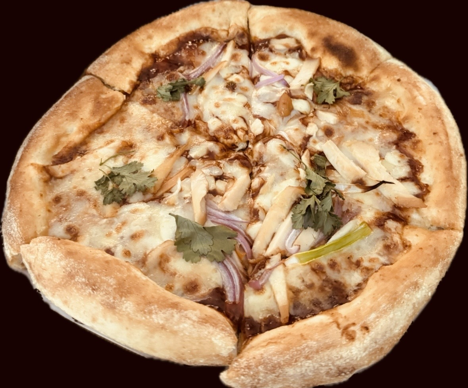

In [132]:
display(raw_image.resize((468, 388)))

### Instructed zero-shot vision-to-language detailed caption generation

In [133]:
base64_image = encode_image(test_image)

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "What is the content of image?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens":256
  }

In [134]:
response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-139993990942816", "object": "chat.completion", "created": 1723797530, "choices": [{"index": 0, "message": {"role": "assistant", "content": " The image shows a slice of pizza resting on a plate. The pizza has a golden-brown crust with various toppings that could include onions, mushrooms, and possibly some herbs or spices. The cheese is melted and appears to be speckled with brown spots, which might indicate some coal-fired oven cooking. The pizza looks to be thin-crust, like a traditional Neapolitan style, and is served on a dark surface, possibly a cutting board or serving platter. "}, "logprobs": null, "finish_reason": "eos_token"}], "usage": {"prompt_tokens": 2555, "completion_tokens": 109, "total_tokens": 2664}}


### Instructed Visual Question Answering (VQA)

In [135]:
base64_image = encode_image(test_image)

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Is it recommended for eating before sport?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens":256
  }

In [136]:
response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-139993419169072", "object": "chat.completion", "created": 1723797545, "choices": [{"index": 0, "message": {"role": "assistant", "content": " The image shows a pizza that appears to be generously topped with various ingredients, including what looks like chicken, vegetables, and possibly cheese. While the nutritional value, taste, and portion size of the pizza will depend on the actual ingredients and preparation, in general, pizza can be enjoyed as a meal before sports or other physical activities.\n\nPizza can provide a balance of carbohydrates and proteins that can be beneficial for energy during sports. However, the nutritional value and suitability of a pizza as a pre-activity meal will depend on factors such as:\n\n1. The type of sports activity: For low-intensity activities like yoga or a light workout, any heavier meal, including pizza, is usually suitable. However, for intense activities like marathons or fighting sports, consuming a heavy meal can lead to disc

In [141]:
base64_image = encode_image(test_image)

inputs = {
    "messages": [
        {
            "role": "user",
            "content": [
                {
                    "type": "text",
                    "text": "Can you list several descriptions for product marketing?"
                },
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{base64_image}"
                    }
                }
            ]
        }
    ],
    "max_tokens":512
  }

In [142]:
response = run_inference(endpoint_name, inputs)
print(response)

{"id": "chatcmpl-139976707679968", "object": "chat.completion", "created": 1723797686, "choices": [{"index": 0, "message": {"role": "assistant", "content": " Certainly! Here are several product marketing descriptions that could be used for the pizza shown in the image:\n\n1. \"Indulge in our artisan-style pizza, a perfect blend of flavors and textures with generous amounts of toppings and a delicious golden-brown crust.\"\n\n2. \"Crafted with care and loaded with the finest ingredients, our pizza has a mouthwatering appeal that's sure to satisfy your cravings!\"\n\n3. \"Experience the taste of authentic Italian cuisine with every bite of our gourmet pizza, featuring a light and crispy crust paired with a medley of succulent toppings.\"\n\n4. \"Savor the richness of our pizza, topped with a variety of fresh vegetables and premium ingredients that create a symphony of flavors on every slice.\"\n\n5. \"Why settle for an ordinary pizza when you can have an extraordinary experience? Our piz

## Clean up
Uncomment the below cell to delete the endpoint and model when you finish the experiment

In [ ]:
#sm_client.delete_model(ModelName=deploy_model_name)
#sm_client.delete_endpoint(EndpointName=endpoint_name)